<a href="https://colab.research.google.com/github/Marwan-Aj/PMASD/blob/main/IDs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import re
import os
from pickle import dump, load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import librosa

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

from keras import Model
from keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, ReLU
from tensorflow.keras import callbacks

## Some parameters + Load dataframes

In [ ]:
PATH = 'drive/MyDrive/PMSAD/'

train, test = {}, {}
machines = ['ToyCar', 'ToyConveyor', 'fan', 'pump', 'slider', 'valve']
for machine in machines : 
  train[machine] = PATH+machine+'/train/*.wav'
  test[machine] = PATH+machine+'/test/*.wav'


params = {'fe':16000,
          'n_fft': 1024,
          'n_mels': 128,
          'frames': 5,
          'hop_length': 512,
          'lower_edge_hertz': 0,
          'upper_edge_hertz': 8000}

logmel_shape = (320, 128, 1)

id_shape=(23)
machine_shape=(6)
asd_shape=(2)
unkPb = 'Problem value must be \'machine\' or \'id\' or \'asd\''


## Dict avec les correspondances ids actuels vers ids dans {0...22}
ids = {}
ids['ToyCar'] = {'04':'03',
                 '03':'02',
                 '02':'01',
                 '01':'00'}
ids['ToyConveyor'] = {'03':'06',
                      '02':'05',
                      '01':'04'}
ids['fan'] = {'06':'10',
              '04':'09',
              '02':'08',
              '00':'07'}
ids['pump'] = {'06':'14',
               '04':'13',
               '02':'12',
               '00':'11'}
ids['slider'] = {'06':'18',
                 '04':'17',
                 '02':'16',
                 '00':'15'}
ids['valve'] = {'06':'22',
                '04':'21',
                '02':'20',
                '00':'19'}


## Charger un df avec les chemins des fichiers audio et leurs classes
## Argument : le chemin vers les données train ou test d'une machine
## Colonnes df : filepath(str), machine(str), id(str, entre '00' et '22'), asd(int, 0 ou 1)
def load_df(path) :
  liste = glob.glob(path)
  df = pd.DataFrame(liste, columns=['filepath'])
  df['machine'] = df['filepath'].apply(lambda x: re.findall(r"(ToyCar|ToyConveyor|fan|pump|slider|valve)", x)[0])
  df['id'] = df['filepath'].apply(lambda x: re.findall(r"[0-9]{2}", x)[0])
  df['id'].replace(ids[df['machine'].unique()[0]], inplace=True)
  df['asd'] = df['filepath'].apply(lambda x: str(re.findall(r"(normal|anomaly)", x)[0])).replace({'normal':1, 'anomaly':0})
  return df


## Charger 2 dfs (train et test) avec l'ensemble des chemins des fichiers audio et leurs classes
## Colonnes df : filepath(str), machine(str), id(str, entre '00' et '22'), asd(int, 0 ou 1)
def load_fulldf() : 
  machine_dfs = []
  for path in train.values() :
    machine_dfs.append(load_df(path))
  df_train = pd.concat(machine_dfs, ignore_index=True)
  machine_dfs = []
  for path in test.values() :
    machine_dfs.append(load_df(path))
  df_test = pd.concat(machine_dfs, ignore_index=True)
  return df_train, df_test


In [ ]:
df_train, df_test = load_fulldf()
print("train :", df_train.shape)
print("test :", df_test.shape)

train : (20119, 4)
test : (10868, 4)


## Load train audio & target data functions

In [ ]:
def load_audio(filepath):
    data, fe = librosa.load(filepath, sr=16000)
    return data, fe
    

def logMelSpectrogram(audio, params):

    stfts = librosa.stft(audio,
                         n_fft = params['n_fft'],
                         hop_length = params["hop_length"],
                         ).T

    power_spectrograms = np.real(stfts * np.conj(stfts))

    num_spectrogram_bins = power_spectrograms.shape[-1]

    linear_to_mel_weight_matrix = librosa.filters.mel(sr=params['fe'],
                                                      n_fft=params['n_fft']+1,
                                                      n_mels=params['n_mels'],
                                                      fmin=params['lower_edge_hertz'],
                                                      fmax=params['upper_edge_hertz']
                                                      ).T

    mel_spectrograms = np.tensordot(power_spectrograms,
                                    linear_to_mel_weight_matrix,
                                    1)

    return (np.log(mel_spectrograms + 1e-6).astype(np.float32))


## Pour charger, dans un narray, les données audio du df en argument
def load_data(df, T_max=10.21):
  X_audio = []
  for i, a_path in enumerate(df.filepath) :
    data, fe = load_audio(a_path)
    if len(data)>= T_max*fe:
      data = data[:int(T_max*fe)]
    else :
      data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])
    spectre_audio = logMelSpectrogram(data, params)
    X_audio.append(spectre_audio)
    if int(i%(df.shape[0]*0.1))==0 : print(i,'on',df.shape[0],'files') 
  print("Done !")
  return np.array(X_audio)


## Pour charger les données target train et test, selon la valeur de problem
def load_target(df_train, df_test, problem) : 
  if problem == 'machine' : 
    ytrain, ytest = df_train.machine, df_test.machine
  elif problem == 'id' : 
    ytrain, ytest = df_train.id, df_test.id
  elif problem == 'asd' : 
    df_train[df_train.machine!=machineRef].asd = 0
    df_train[(df_train.machine==machineRef) & (df_train.id!=idRef)].asd = 0
    ytrain, ytest = df_train.asd, df_test.asd
  else : raise ValueError(unkPb)
  return ytrain, ytest

In [ ]:
## On charge l'ensemble des données logmel d'entraînement
Xtrain_full = load_data(df_train)

0 on 20119 files
2012 on 20119 files
4024 on 20119 files
6036 on 20119 files
8048 on 20119 files
10060 on 20119 files
12072 on 20119 files
14084 on 20119 files
16096 on 20119 files
18108 on 20119 files
Done !


In [ ]:
## Selon le problème en argument, on charge l'ensemble des données target (train + test)
ytrain_full, ytest_full = load_target(df_train, df_test, problem='id')

## Scale + reshape train & validation data

In [ ]:
X = Xtrain_full
y = ytrain_full
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = preprocessing.MinMaxScaler()

X_train = X_train.reshape([-1, X_train.shape[1] * X_train.shape[2]])
X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape([-1, X.shape[1], X.shape[2], 1])
y_train = to_categorical(y_train)

X_valid = X_valid.reshape([-1, X_valid.shape[1] * X_valid.shape[2]])
X_valid = scaler.transform(X_valid)
X_valid = X_valid.reshape([-1, X.shape[1], X.shape[2], 1])
y_valid = to_categorical(y_valid)

## On sauvegarde le data scaler
dump(scaler, open(PATH+'scaler.pkl', 'wb'))

print(X_train.shape, y_train.shape) 
print(X_valid.shape, y_valid.shape)

(18107, 320, 128, 1) (18107, 23)
(2012, 320, 128, 1) (2012, 23)


## Model using Conv2D for IDs classification

In [ ]:
def relu_bn(inputs) :
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn


def create_model(yshape, Xshape=logmel_shape):

  inputs = Input(shape=Xshape)

  x = Conv2D(32, (5, 5), strides=(2,1), padding='same')(inputs)
  x = relu_bn(x)
  x = Conv2D(64, (5, 5), strides=(2,1), padding='same')(x)
  x = relu_bn(x)
  x = Conv2D(128, (3, 3), strides=(1,1), padding='same')(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Conv2D(256, (3, 3), strides=(1,1), padding='same')(x)
  x = relu_bn(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Conv2D(512, (3, 3), strides=(1,1), padding='same')(x)
  x = relu_bn(x)
  x = MaxPooling2D(pool_size=2)(x)

  x = Flatten()(x)

  x = Dense(units = 512)(x)
  x = relu_bn(x)
  x = Dropout(0.2)(x)
  x = Dense(units = 512)(x)
  x = relu_bn(x)
  x = Dropout(0.2)(x)
  x = Dense(units = 1024)(x)
  x = relu_bn(x)
  x = Dropout(0.2)(x)
  x = Dense(units = 1024)(x)
  x = relu_bn(x)

  outputs = Dense(units=yshape, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model



lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 10,
                                         factor = 0.5,
                                         verbose = 0,
                                         mode = 'min')

checkpoint = callbacks.ModelCheckpoint(filepath = PATH+'checkpoint',
                                       save_weights_only = True,
                                       monitor = 'val_acc',
                                       mode = 'max',
                                       save_best_only = True)


In [ ]:
model = create_model(yshape=id_shape)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 32)      832       
_________________________________________________________________
re_lu (ReLU)                 (None, 160, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 128, 64)       51264     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 80, 128, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 128, 64)       256   

Epoch 1/100
71/71 [==============================] - 92s 1s/step - loss: 1.6579 - acc: 0.5033 - val_loss: 8.8102 - val_acc: 0.0527
Epoch 2/100
71/71 [==============================] - 73s 1s/step - loss: 0.1617 - acc: 0.9435 - val_loss: 13.2534 - val_acc: 0.0527
Epoch 3/100
71/71 [==============================] - 73s 1s/step - loss: 0.0768 - acc: 0.9751 - val_loss: 17.0270 - val_acc: 0.0472
Epoch 4/100
71/71 [==============================] - 73s 1s/step - loss: 0.0448 - acc: 0.9846 - val_loss: 38.3964 - val_acc: 0.0472
Epoch 5/100
71/71 [==============================] - 73s 1s/step - loss: 0.0240 - acc: 0.9919 - val_loss: 65.9712 - val_acc: 0.0586
Epoch 6/100
71/71 [==============================] - 73s 1s/step - loss: 0.0193 - acc: 0.9941 - val_loss: 36.1804 - val_acc: 0.0492
Epoch 7/100
71/71 [==============================] - 73s 1s/step - loss: 0.0169 - acc: 0.9940 - val_loss: 15.2714 - val_acc: 0.1262
Epoch 8/100
71/71 [==============================] - 73s 1s/step - loss: 0.02

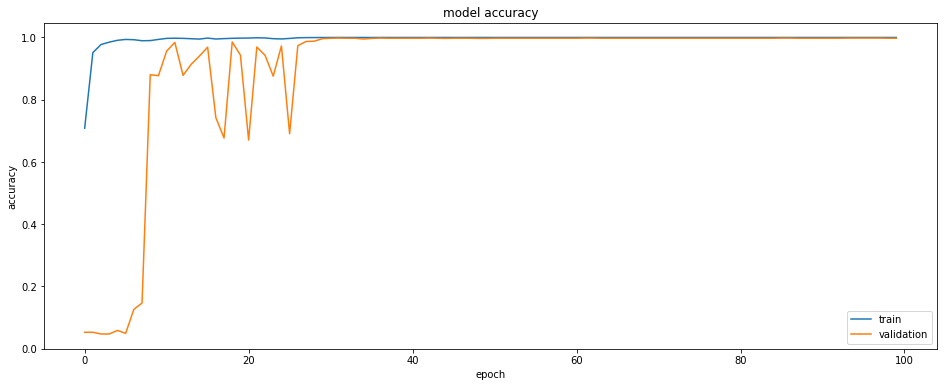

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=256, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks = [lr_plateau, checkpoint],
                    verbose=1)

plt.figure(figsize=(16,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()